In [1]:
import sys
import os
import os.path as op

import numpy as np
import pandas as pd
import xarray as xr
import glob
import matplotlib.pyplot as plt
import great_circle_calculator.great_circle_calculator as gcc
from scipy.signal import argrelextrema


# dev library
import sys
sys.path.insert(0, op.join(os.path.abspath(''), '..', '..'))

# dependencies
from lib import wrapSpectra, plot_sat, spectra
from lib.config import * 


<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


<span style='background:#FDD633'> **TODO:**<br>
     </span>


# Storage Energy Bins

In [2]:
ds_data = xr.open_dataset(op.join(r'/media/administrador/DiscoHD/Documentos/notebook_projects/cfosat-forecast/output', 'ds_data_csiro.nc'))

In [3]:
# in CSIRO -> Wave to direction; we are interesect in wave from
ds_data['direction'] = xr.where(ds_data.direction > 180, ds_data.direction -180, ds_data.direction + 180)
ds_data['efth'] = ds_data['efth'] * np.pi / 360
ds_data = ds_data.sortby('direction', 'frequency')

In [4]:
ds_data['longitude'] = xr.where(ds_data['longitude'] > 180, ds_data['longitude'] - 360, ds_data['longitude'])

In [5]:
d_ang = np.unique(np.diff(ds_data.direction))
d_freq = np.diff(np.append(0, ds_data.frequency))

In [6]:
df_info = pd.DataFrame()
dst = xr.Dataset({'station':[]})

for st in np.sort(ds_data.station.values):
    
    sys.stdout.write('\r Station {0}'.format(st))
    sys.stdout.flush()
    
    # select station
    ds_sti = ds_data.sel(station=st)
    
    # longitude, latitude coordinates
    lon, lat = np.unique(ds_sti.longitude.values), np.unique(ds_sti.latitude.values)
    
    distance, bearing_p1, bearing_p2 = spectra.geoBearing(lon, lat)
    #BEARING_P2 = gcc.bearing_at_p2([site_lon, site_lat], [lon, lat])
    
    # add station info to pandas dataframe
    df = pd.DataFrame({'station': st, 'bearing_p1':bearing_p1, 'distance':distance, 'lon':lon, 'lat':lat})
    df_info = pd.concat([df_info, df])
    
    # select sector that travels along geodesic in direction bearing_p2
    ds_stdir = ds_sti.isel(direction = np.argsort(np.abs(ds_sti.direction - bearing_p2))[0])
    
    # wave statistics
    T = 1/ds_stdir.frequency
    C = g * T / (2 * np.pi)
    Cg = 0.5 * C
    Ttime = (distance / Cg).to_dataset(name='Ttime')
    Date = [i + pd.to_timedelta(Ttime.Ttime.values, unit='s') for i in ds_sti['time'].values]
    
    H = 4 * np.sqrt(ds_stdir.efth * d_ang * d_freq).to_dataset(name='H')
    H = H.assign({'Date': (('time', 'frequency'), Date)})
    
    dsT = xr.combine_by_coords([H, Ttime, ds_stdir[['wnd', 'wnddir']]]).expand_dims('station')
    dst = xr.combine_by_coords([dsT, dst])
    

 Station 3661

In [7]:
ds_info = df_info.set_index('station').to_xarray()
dataset = xr.combine_by_coords([ds_info, dst])
dataframe = dataset.to_dataframe()[['H', 'Date', 'Ttime', 'bearing_p1', 'distance', 'lon', 'lat', 'wnd', 'wnddir']].reset_index()

In [144]:
# count bins
time_ini, time_fin = forecast_day, forecast_day + datetime.timedelta(days=10)

bins_dirs = np.arange(0, 360, 5)
bins_date = pd.date_range(time_ini, time_fin, freq='3H')
bins_k = np.unique(dataframe.frequency.values)

In [9]:
#matrix = count_bins(dataframe, bins_dirs, bins_date, bins_k)

In [10]:
#matrix.to_netcdf(op.join(r'/media/administrador/DiscoHD/Documentos/notebook_projects/cfosat-forecast/output', 'runners_BINScsiro.nc'))

## Interpretation of Swell Dissipation

In [11]:
sys.exit()

SystemExit: 

In [82]:
155-90

65

In [84]:
1/dataframe.frequency.values[1]

25.974026114768936

In [89]:
1/dataframe.frequency.values[5]

17.740608665711022

In [116]:
1/dataframe.frequency.values[7]

14.661661095352333

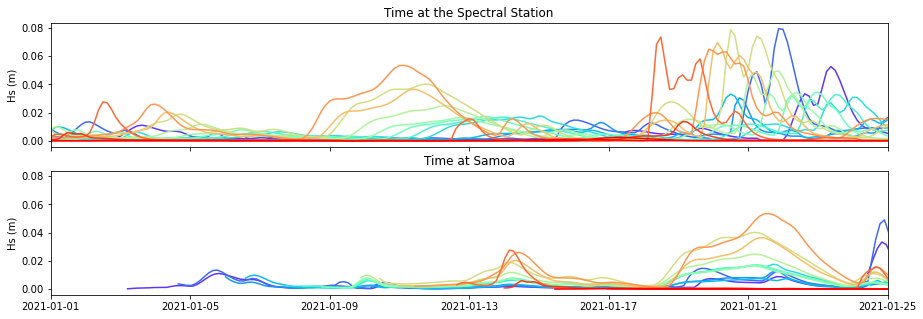

In [124]:
from matplotlib import cm

dataR = dataframe.loc[(dataframe.bearing_p1>145) & (dataframe.bearing_p1<155) & (dataframe.frequency == np.unique(dataframe.frequency.values)[7]) ]
dts = np.sort(np.unique(dataR.distance.values))

cm1 = cm.get_cmap('rainbow', len(dts))
colors = cm1(np.linspace(0.1, 1, len(dts)))

fig, axs = plt.subplots(2, figsize=(15,5), sharex=True)

for pst, st in enumerate(dts):
    df = dataR.loc[dataR.distance == st]
    
    #axs[0].plot(df.time, df.wnd, c=colors[pst])
    axs[0].plot(df.time, df.H, c=colors[pst], label='St Distance {0} km'.format(int(np.unique(df.distance.values)/1000)))
    axs[1].plot(df.Date, df.H, c=colors[pst], label='St Distance {0} km'.format(int(np.unique(df.distance.values)/1000)))

axs[1].set_xlim(np.datetime64('2021-01-01T00:00:00.000000000'), np.datetime64('2021-01-25T00:00:00.000000000'))
axs[0].set_ylabel('Hs (m)')
axs[1].set_ylabel('Hs (m)')
axs[0].set_title('Time at the Spectral Station')
axs[1].set_title('Time at Samoa')
#axs[0].legend(ncol=2, loc='upper right')
plt.show()

In [175]:
dataset = xr.Dataset({'freq':[]})
idstorm = 0
for pk, bin_k in enumerate(bins_k[:-1]):
    for pdir, bin_dir in enumerate(bins_dirs[:-1]):
        #print(bin_dir)
        df_dir = dataframe.loc[(dataframe.bearing_p1 > bin_dir) & (dataframe.bearing_p1 < bins_dirs[pdir+1]) & (dataframe.frequency > bin_k) & (dataframe.frequency <= bins_k[pk+1])]
        #df_dir = dataframe.loc[(dataframe.frequency > bin_k) & (dataframe.frequency < bins_k[pk+1])]
        #sys.exit()
        df_k = df_dir.sort_values('Date')
        df_k = df_k.loc[df_k.H > 0]

        df_envelope = pd.DataFrame()
        for st in np.unique(df_k.station.values):
            df_st = df_k.loc[df_k.station == st]
            df_st = df_st.set_index('Date').resample('3H').max()
            df_st = df_st.where(df_st.H > 0.1, 0)
            df_envelope = pd.concat([df_envelope, df_st])
            df_envelope = df_envelope.groupby(df_envelope.index).sum()
            plt.plot(df_st.index, df_st.H)
        #sys.exit()
        if not df_envelope.empty:
            # positions of local
            #df_envelope = df_envelope.where(df_envelope.H > 0.0001, 0)
            zero_crossings = np.where(np.diff(np.sign(df_envelope.H)))[0]


            for pcross, cross in enumerate(zero_crossings[::2][:-1]):
                Hmaxs, dists = [], []

                for st in np.unique(df_k.station.values):
                    df_st = df_k.loc[df_k.station == st]
                    df_time = df_st.loc[(df_st.Date > df_envelope.index[cross]) & (df_st.Date < df_envelope.index[zero_crossings[::2][pcross+1]])]
                    if not df_time.empty:
                        Hmaxs.append(np.nanmax(df_time.H.values))
                        dists.append(np.unique(df_time.distance))

                Hmaxs = np.array(Hmaxs).reshape(-1)
                dists = np.array(dists).reshape(-1)
                #sys.exit()
                # eliminate observations smaller than the H peak
                Hmaxs = Hmaxs[np.argsort(dists, axis=0)]
                dists = np.sort(dists)
                pmax = np.where(Hmaxs == np.nanmax(Hmaxs))[0][0]
                Hmaxs = Hmaxs[:pmax+1]
                dists = dists[:pmax+1]

                if len(Hmaxs) > 2:

                    ds = xr.Dataset({'distances': (('storm', 'id'), np.array(dists).reshape(1, -1)), 'H': (('storm', 'id'), np.array(Hmaxs).reshape(1, -1))}, coords={'id':range(len(dists)),  'storm': [idstorm]})
                    #sys.exit()
                    ds = ds.assign({'freq': [bin_k], 'dir': [bin_dir]})
                    idstorm = idstorm + 1
                    dataset = xr.concat([dataset, ds], dim='freq')
                

In [181]:
def monotonic(x):
    dx = np.diff(x)
    return np.all(dx >= 0)

In [196]:
cm1 = cm.get_cmap('hot', len(bins_k))
colors = cm1(np.linspace(0, 1, len(bins_k)-3))

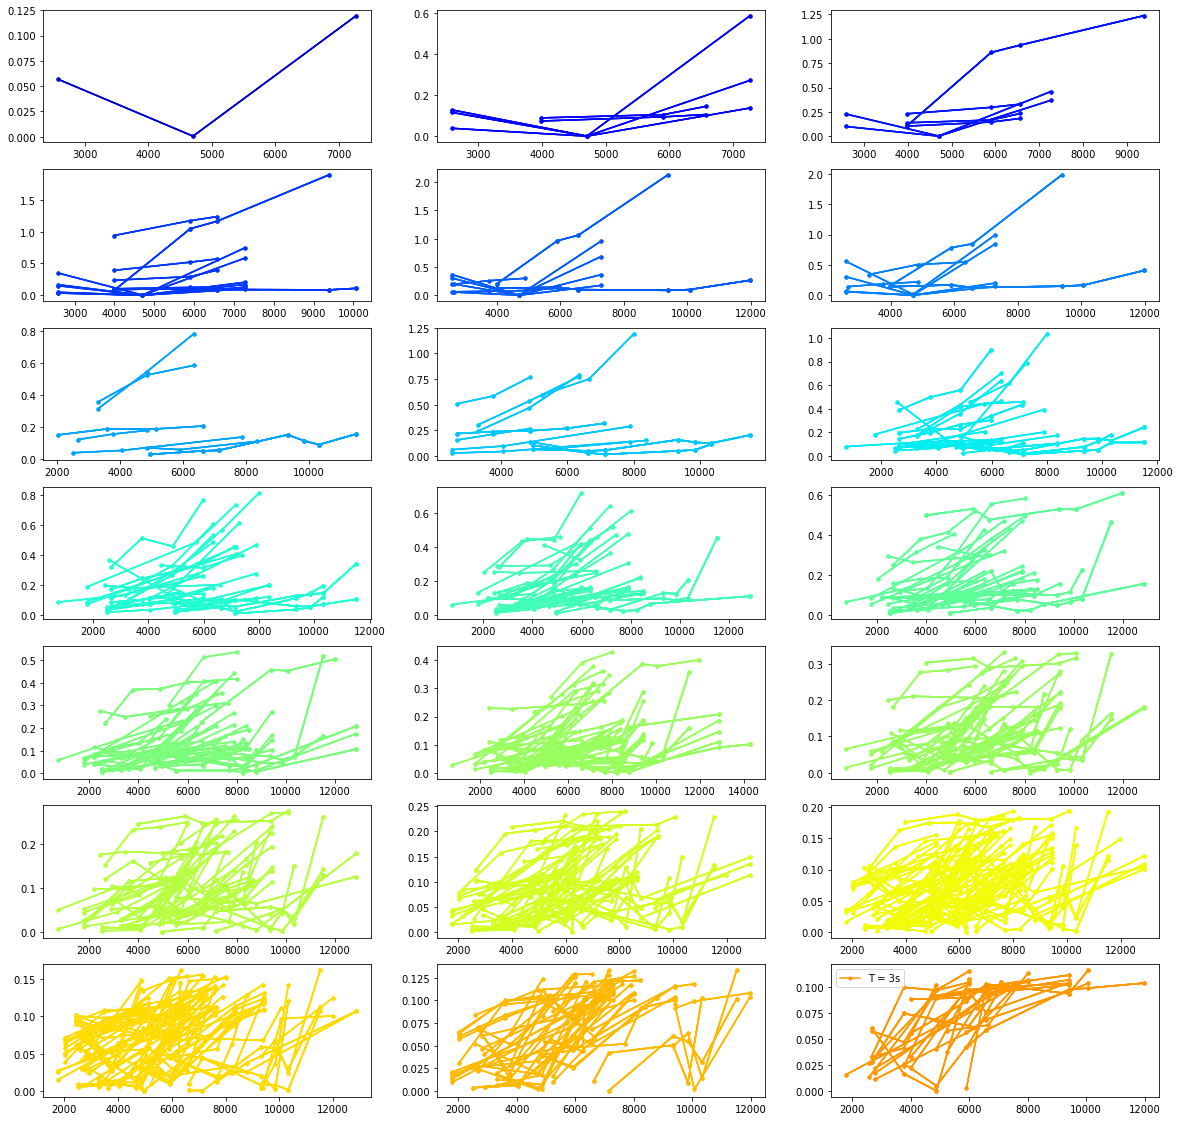

In [178]:
fig = plt.figure(figsize=(20, 20))
i = 1
freqs = np.unique(dataset.freq.values)
dirs = np.unique(dataset.dir.values)

for pfreq, freq in enumerate(freqs[:]):
    ax = fig.add_subplot(int(np.ceil(len(freqs)/3)), 3, i)
    #print(i)
    ax.plot([], [], '.-', c=colors[pfreq], label='T = {0}s'.format(int(1/freq)))
    for dire in dirs[:1]:
        
        
        #ax.set_title('T {0}s'.format(int(1/freq)))
        xds = dataset.sel(dir=dire, freq=freq).to_dataframe().dropna().reset_index()

        for storm in xds.storm.values:
            xds_st = xds.loc[xds.storm == storm].sort_values('distances')
            #if monotonic(xds_st.H.values):
                
            ax.plot(xds_st.distances/1000, xds_st.H, '.-', c=colors[pfreq])
                #break

    i = i + 1
plt.legend()
plt.show()

In [194]:
%matplotlib

Using matplotlib backend: QtAgg


In [206]:
cm1 = cm.get_cmap('Spectral', 9)
colors = cm1(np.linspace(0, 1, 9))

In [207]:
fig = plt.figure(figsize=(12, 5))
i = 1
freqs = np.unique(dataset.freq.values)
dirs = np.unique(dataset.dir.values)

for pfreq, freq in enumerate(freqs[1:9]):
    #ax = fig.add_subplot(int(np.ceil(len(freqs)/3)), 3, i)
    #print(i)
    plt.plot([], [], '.-', c=colors[pfreq], label='T = {0}s'.format(int(1/freq)))
    for dire in dirs[:1]:
        
        
        #ax.set_title('T {0}s'.format(int(1/freq)))
        xds = dataset.sel(dir=dire, freq=freq).to_dataframe().dropna().reset_index()

        for storm in xds.storm.values:
            xds_st = xds.loc[xds.storm == storm].sort_values('distances')
            if monotonic(xds_st.H.values):
                
                plt.plot(xds_st.distances/1000, xds_st.H, '.-', c=colors[pfreq])
                

    i = i + 1
plt.ylabel('H (m)', fontweight='bold')
plt.xlabel('Distance (m)', fontweight='bold')
plt.legend(ncol=2)
plt.show()